# Forward-only Backend

> An efficient backend when the components in circuit have low back-reflection. In this case, only forward-direction matrix multiplication is calculated to reduce computational cost for complicated circuit. The improvement compared to other backends ('klu' for example) is demonstrated with an example of cascaded AMZI structure.

In [1]:
import sax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

> Define waveguide and directional coupler components

In [2]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict


def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict

> Create a cascaded AMZI structure with n identical AMZIs, with the next AMZI is connected to the "cross" port of the previous one. 

In [3]:
def cascaded_amzi_generator(n, backend="klu"):
    netlist = {
        "instances": {},
        "connections": {},
        "ports": {},
    }

    models = {
        "coupler": coupler,
        "waveguide": waveguide,
    }

    # Build the netlist
    for i in range(1, n + 1):
        # Define instance names
        left_name = f"left_{i}"
        right_name = f"right_{i}"
        top_name = f"top_{i}"
        btm_name = f"btm_{i}"

        # Add instances
        netlist["instances"][left_name] = "coupler"
        netlist["instances"][right_name] = "coupler"
        netlist["instances"][top_name] = "waveguide"
        netlist["instances"][btm_name] = "waveguide"

        # Internal connections within AMZI i
        netlist["connections"][f"{left_name},out0"] = f"{btm_name},in0"
        netlist["connections"][f"{btm_name},out0"] = f"{right_name},in0"

        netlist["connections"][f"{left_name},out1"] = f"{top_name},in0"
        netlist["connections"][f"{top_name},out0"] = f"{right_name},in1"

        if i > 1:
            # Connections between AMZIs via the cross port
            prev_right_name = f"right_{i - 1}"
            netlist["connections"][f"{prev_right_name},out0"] = f"{left_name},in1"
            netlist["connections"][f"{prev_right_name},out1"] = f"{left_name},in0"

    # Define external ports
    netlist["ports"]["in0"] = "left_1,in0"
    netlist["ports"]["in1"] = "left_1,in1"
    netlist["ports"]["out0"] = f"right_{n},out0"
    netlist["ports"]["out1"] = f"right_{n},out1"

    # Create the circuit
    mzi_ideal, info = sax.circuit(netlist=netlist, models=models, backend=backend)
    return mzi_ideal, info

> Consider a case with 20 cascaded AMZIs

In [4]:
wavelengths = np.linspace(1.500, 1.600, 100_000)
n = 10
params = {"wl": wavelengths}
for i in range(1, n + 1):
    params[f"left_{i}"] = {"coupling": 0.5}
    params[f"right_{i}"] = {"coupling": 0.5}
    params[f"top_{i}"] = {"length": 50}
    params[f"btm_{i}"] = {"length": 0}

> Run simulation with 'klu' backend and 'forward-only' backend

In [5]:
%%time
mzi_ideal, info = cascaded_amzi_generator(n, backend="klu")
S = mzi_ideal(**params)
transmissions_klu = 10 * jnp.log10(jnp.abs(S["in0", "out1"]) ** 2)

CPU times: user 3.21 s, sys: 2.5 s, total: 5.71 s
Wall time: 4.7 s


In [6]:
%%time
mzi_ideal, info = cascaded_amzi_generator(n, backend="forward")
S = mzi_ideal(**params)
transmissions_forward = 10 * jnp.log10(jnp.abs(S["in0", "out1"]) ** 2)

CPU times: user 336 ms, sys: 182 ms, total: 518 ms
Wall time: 338 ms


> As the circuit becomes more complex, the forward-only backend experiences a more significant speed-up, and the results remain accurate as long as there is no backreflection.

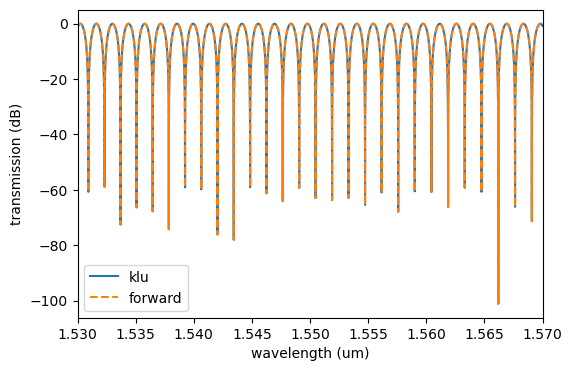

In [7]:
fig, axs = plt.subplots(figsize=(6, 4))

plt.plot(wavelengths, transmissions_klu, label="klu")
plt.plot(wavelengths, transmissions_forward, "--", label="forward")

plt.xlim(1.53, 1.57)
plt.xlabel("wavelength (um)")
plt.ylabel("transmission (dB)")
plt.legend()
plt.show()